In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib


class Sticker:
    def __init__(self,filename,img_bgr=None,img_rgb=None,img_show_rgb=None,img_show=None, dlib_rects=None):
        self.result = 0
        self.filename = filename

    #원본 이미지파일의 이름을 받아서 변수에 저장하고 반환
    def image_load(self) :
        my_image_path = (os.getenv('HOME')+'/aiffel/camera_sticker/images/'+self.filename+".png")
        self.img_bgr = cv2.imread(my_image_path)
        self.img_show = self.img_bgr.copy()
        self.img_rgb = cv2.cvtColor(self.img_bgr, cv2.COLOR_BGR2RGB)  
        return self.img_rgb
        
    #얼굴 영역을 찾아서 변수에 저장하고 반환
    def detect_face(self):
        detector_hog = dlib.get_frontal_face_detector()
        self.dlib_rects = detector_hog(self.img_rgb, 1)

        for dlib_rect in self.dlib_rects:
            l = dlib_rect.left()
            t = dlib_rect.top()
            r = dlib_rect.right()
            b = dlib_rect.bottom()

            cv2.rectangle(self.img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

        self.img_show_rgb =  cv2.cvtColor(self.img_show, cv2.COLOR_BGR2RGB)
        plt.imshow(self.img_show_rgb)
        return self.img_show_rgb
             
    #랜드마크 모델을 로드한뒤 지정한 위치에 스티커를 붙이고 이미지를 반환
    def attach_sticker(self) :
        model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
        landmark_predictor = dlib.shape_predictor(model_path)

        list_landmarks = []
        for dlib_rect in self.dlib_rects:
            points = landmark_predictor(self.img_rgb, dlib_rect)
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            list_landmarks.append(list_points)
            
        for dlib_rect, landmark in zip(self.dlib_rects, list_landmarks):
            #print (landmark[30]) # nose center index : 30
            x = landmark[30][0]
            y = landmark[30][1]
            
            #좌우 각도에 따라 눈 간격을 기준으로 크기를 조절해주는 코드를 작성하였으나
            #코가 포함되어있는 이미지 특성상 이미지가 어색하게 찌그러지는 문제가 있어서 삭제함           
            #rEye = (landmark[45][0] - landmark[27][0])
            #lEye = (landmark[27][0] - landmark[36][0])
            #prop_w = (lambda x, y : x if x < y else y)(rEye,lEye)  / (lambda x, y : x if x > y else y)(rEye,lEye)
            
            w = dlib_rect.width() #* prop_w
            #미간과 코, 코와 아래입술의 비율을 기준으로 얼굴이 상하로 기울여저 있는지 판단, h크기를 조절함           
            prop_h = (landmark[30][1] - landmark[27][1]) / (landmark[57][1] - landmark[27][1]) * 2
            h = dlib_rect.width() * prop_h
            h = int(h)        

        sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
        img_sticker = cv2.imread(sticker_path)
        img_sticker = cv2.resize(img_sticker, (w,h))

        refined_x = x - w // 2  # left
        refined_y = y - h // 2  # top

        if refined_y < 0 :
            img_sticker = img_sticker[-refined_y:]

        sticker_area = self.img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]]

        self.img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)  
        
        alpha = 0.5       
        
        result = cv2.cvtColor(self.img_bgr, cv2.COLOR_BGR2RGB)
        return result

스티커앱 기능을 구현하기 위한 클래스이다.
다양한 사진들에 기능을 적용시키는 모습을 한눈에 보여주기 위해 클래스로 작성하였다.

기존 기능에 더하여 얼굴의 상하 각도에 따라서 스티커의 y축 크기를 조절하는 기능을 추가하였다
랜드마크의 미간과 코 중앙 사이의 간격과 코 중앙과 입술 아래의 간격의 비율을 근거로 얼굴각도에 따라 수염의 크기를 조절한다


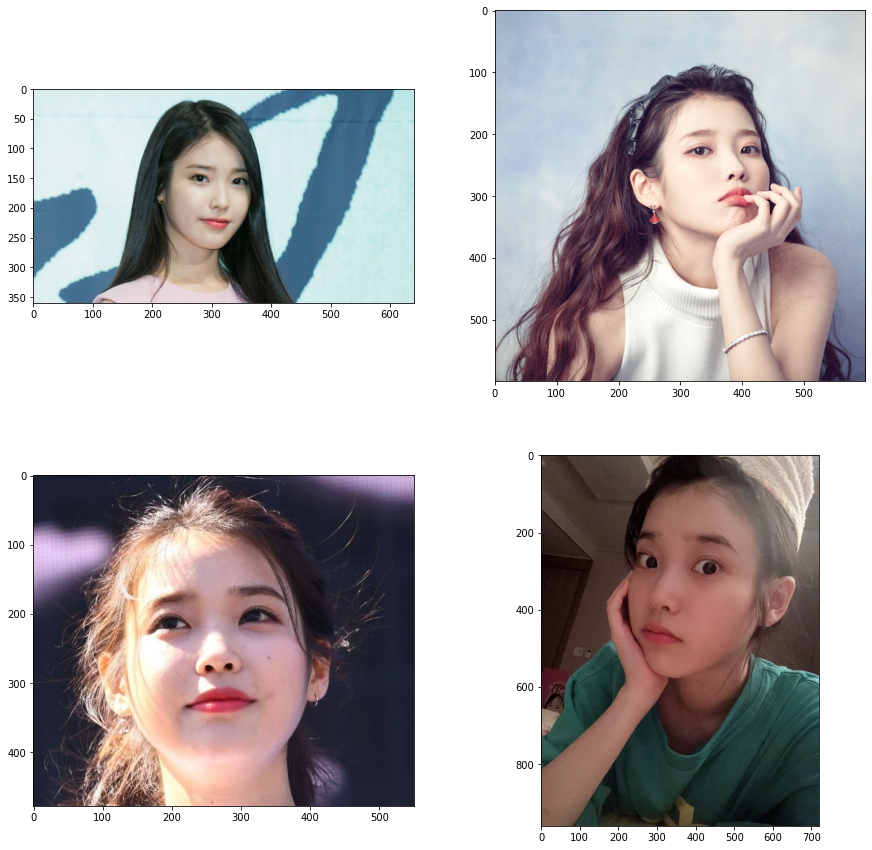

In [6]:
image1 = Sticker("image1")
image2 = Sticker("image2")
image3 = Sticker("image3")
image4 = Sticker("image4")

plt.figure(figsize = (15,15))

plt.subplot(221)
plt.imshow(image1.image_load())

plt.subplot(222)
plt.imshow(image2.image_load())

plt.subplot(223)
plt.imshow(image3.image_load())

plt.subplot(224)
plt.imshow(image4.image_load())
plt.show()


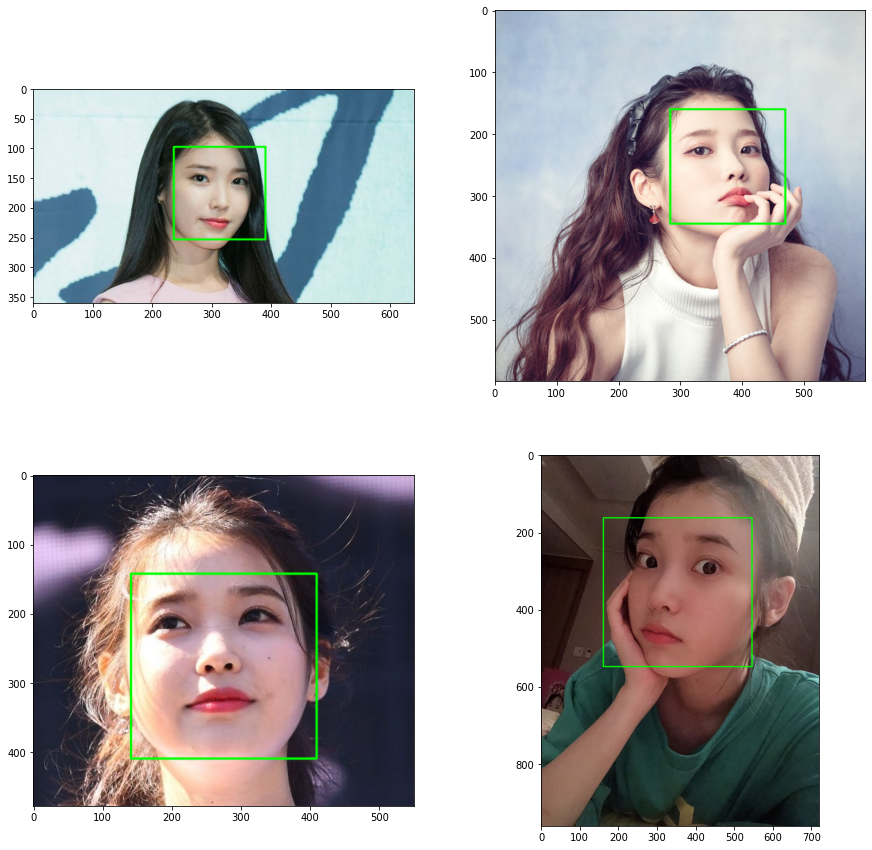

In [7]:
plt.figure(figsize = (15,15))

plt.subplot(221)
plt.imshow(image1.detect_face())

plt.subplot(222)
plt.imshow(image2.detect_face())

plt.subplot(223)
plt.imshow(image3.detect_face())

plt.subplot(224)
plt.imshow(image4.detect_face())
plt.show()

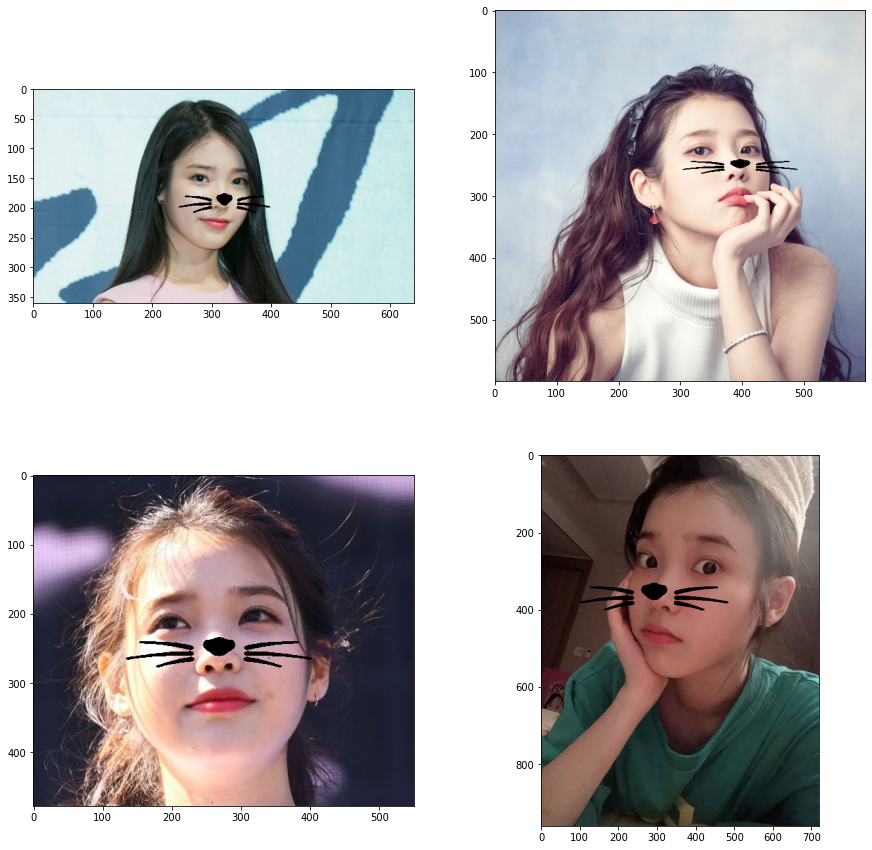

In [8]:
plt.figure(figsize = (15,15))

plt.subplot(221)
plt.imshow(image1.attach_sticker())

plt.subplot(222)
plt.imshow(image2.attach_sticker())

plt.subplot(223)
plt.imshow(image3.attach_sticker())

plt.subplot(224)
plt.imshow(image4.attach_sticker())
plt.show()

결과는 다양한 각도와 밝기, 크기의 사진들에 정상적으로 고양이 수염 이미지가 합성되었으며
각도에 따라 적당한 변형이 되는것도 확인할 수 있었다.